In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
from SIRD_deepxde_class import SIRD_deepxde_net
from SIRD_deepxde_class import Plot

Using backend: pytorch



# Create synthetic data

In [2]:
alpha_real = 0.2
beta_real = 0.05
gamma_real = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  5000000.000000002


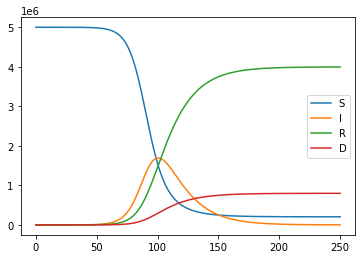

In [3]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t_synth, wsol_synth, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
solver.plot_SIRD(t_synth, wsol_synth)

Use cell below if we want to subset timestep - ie simulate if we are at an early stage in the pandemic so have limited data

In [4]:
# keep this even if not subsetting
t = t_synth
wsol = wsol_synth

# subset
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

# Create model
Code has been wrapped in a custom class that wraps around the deepxde model

In [5]:
model = SIRD_deepxde_net(t, wsol)

In [6]:
model.init_model(print_every=1000)

Compiling model...
'compile' took 0.000311 s



In [7]:
model.train_model(iterations=8000)

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.72e-04, 5.00e-03, 5.44e-03, 9.35e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 4.74e-01, 9.71e-02, 2.71e-01, 9.44e-01, 1.58e-03, 3.49e-03, 4.14e-02, 9.76e-01]    [1.72e-04, 5.00e-03, 5.44e-03, 9.35e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 4.74e-01, 9.71e-02, 2.71e-01, 9.44e-01, 1.58e-03, 3.49e-03, 4.14e-02, 9.76e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [7.04e-06, 2.94e-06, 4.23e-06, 1.36e-06, 5.26e-06, 1.36e-06, 1.07e-05, 3.47e-07, 2.80e-04, 8.57e-05, 1.66e-04, 1.47e-05, 2.53e-03, 1.94e-04, 6.09e-04, 6.45e-06]    [7.04e-06, 2.94e-06, 4.23e-06, 1.36e-06, 5.26e-06, 1.36e-06, 1.07e-05, 3.47e-07, 

# Investigate output
First use the predicted parameters from the neural network to solve the ODE

In [8]:
alpha_nn, beta_nn, gamma_nn = model.get_predicted_params()
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

In [9]:
# we need to set the synthetic data as it comes from outside the network
# the two functions below sets the synthetic data
model.set_synthetic_data(t_synth, wsol_synth) 
model.set_nn_synthetic_data(t_nn_param, wsol_nn_param)

In [10]:
plot = Plot(model) # class that contains plotting functions

The plots below show two things:  
* A comparison between the data we have and what the PINN predicts in this range
* A comparison between the synthetic data in the whole range and the result from using the predicted parameters in the ODE solver

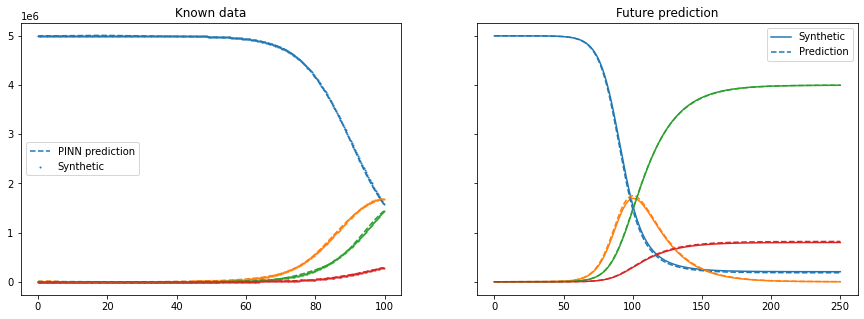

In [11]:
plot.show_known_and_prediction()

# Same as before with even less data
The timing of the data is important. We want to predict as early as possible in the pandemic, so investigate what the effect is of having less data.

In [12]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [13]:
model_less = SIRD_deepxde_net(t, wsol)
model_less.init_model(print_every=1000)
model_less.train_model(iterations=11000)

Compiling model...
'compile' took 0.000449 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.40e-03, 1.69e-03, 4.05e-03, 1.69e-02, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 4.54e-01, 3.99e-02, 1.56e-01, 1.31e+00, 2.04e-01, 1.11e-01, 7.87e-02, 1.26e+00]    [1.40e-03, 1.69e-03, 4.05e-03, 1.69e-02, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 4.54e-01, 3.99e-02, 1.56e-01, 1.31e+00, 2.04e-01, 1.11e-01, 7.87e-02, 1.26e+00]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [1.88e-05, 3.78e-06, 1.33e-06, 9.26e-07, 6.78e-05, 4.66e-07, 1.37e-06, 6.47e-06, 6.79e-04, 2.97e-04, 4.91e-05, 5.25e-06, 1.32e-03, 6.40e-04, 1.19e-04, 2.13e-05]    [1.88e-05, 3.78e-06, 1.33e-06, 9.26

In [14]:
alpha_nn, beta_nn, gamma_nn = model_less.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.1776309758424759, beta: 0.043234147131443024, gamma: 0.00977203156799078


In [15]:
model_less.set_synthetic_data(t_synth, wsol_synth)
model_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less = Plot(model_less)

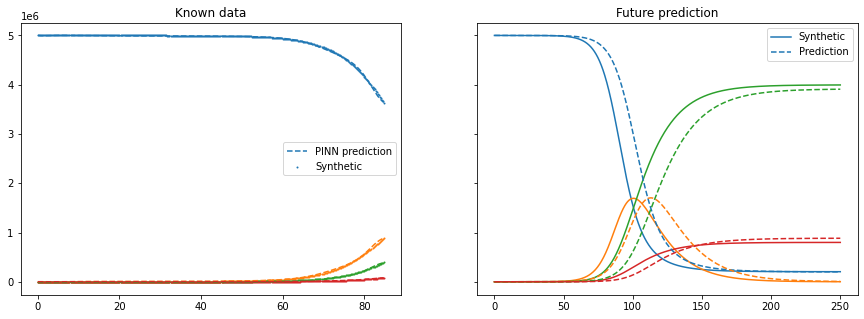

In [16]:
plot_less.show_known_and_prediction()

# Even less data

In [17]:
max_timestep = 75
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [18]:
model_less_2 = SIRD_deepxde_net(t, wsol)
model_less_2.init_model(print_every=1000)
model_less_2.train_model(iterations=11000)

Compiling model...
'compile' took 0.000117 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.04e-02, 1.45e-02, 1.08e-02, 7.01e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 5.77e-02, 7.38e-01, 4.36e-01, 2.86e-03, 5.98e-03, 9.35e-01, 5.16e-01, 3.29e-03]    [1.04e-02, 1.45e-02, 1.08e-02, 7.01e-03, 1.00e+00, 4.00e-12, 0.00e+00, 0.00e+00, 5.77e-02, 7.38e-01, 4.36e-01, 2.86e-03, 5.98e-03, 9.35e-01, 5.16e-01, 3.29e-03]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [7.80e-06, 3.24e-06, 7.83e-07, 7.97e-07, 4.43e-06, 3.02e-06, 2.15e-06, 2.50e-06, 8.45e-04, 4.21e-04, 4.46e-05, 1.86e-05, 9.16e-06, 3.34e-05, 2.72e-05, 2.40e-05]    [7.80e-06, 3.24e-06, 7.83e-07, 7.97

In [19]:
alpha_nn, beta_nn, gamma_nn = model_less_2.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.08224903047084808, beta: 0.013131452724337578, gamma: 5.570765642914921e-05


In [20]:
model_less_2.set_synthetic_data(t_synth, wsol_synth)
model_less_2.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less_2 = Plot(model_less_2)

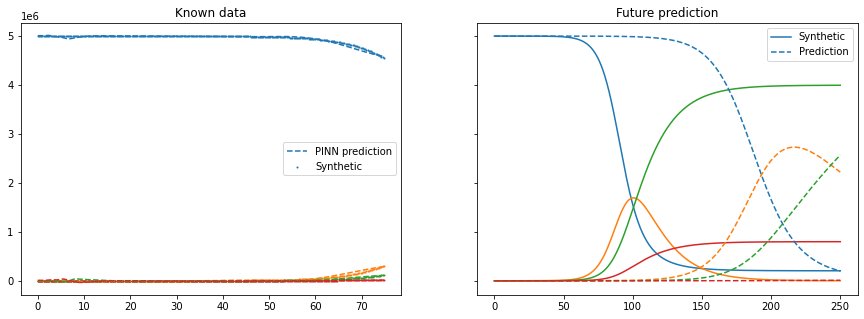

In [21]:
plot_less_2.show_known_and_prediction()

# With noise

In [22]:
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [23]:
wsol = solver.add_noise(wsol, scale=150000)

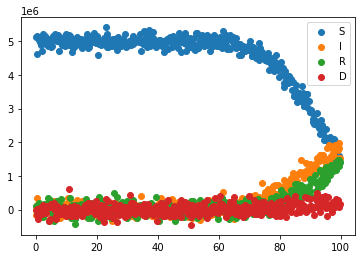

In [24]:
solver.plot_SIRD_scatter(t, wsol)

In [25]:
model_noise = SIRD_deepxde_net(t, wsol)
model_noise.init_model(print_every=1000)
model_noise.train_model(iterations=10000)

Compiling model...
'compile' took 0.000131 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [5.16e-04, 7.19e-03, 1.16e-03, 1.84e-03, 1.02e+00, 9.48e-04, 4.40e-04, 5.77e-06, 1.57e+00, 1.47e-01, 4.99e-03, 2.19e-01, 5.20e-01, 3.61e-01, 2.84e-02, 2.73e-01]    [5.16e-04, 7.19e-03, 1.16e-03, 1.84e-03, 1.02e+00, 9.48e-04, 4.40e-04, 5.77e-06, 1.57e+00, 1.47e-01, 4.99e-03, 2.19e-01, 5.20e-01, 3.61e-01, 2.84e-02, 2.73e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [3.89e-05, 5.05e-06, 3.53e-06, 1.43e-06, 1.88e-05, 4.23e-06, 1.23e-05, 7.00e-08, 1.19e-03, 1.02e-03, 1.09e-03, 8.36e-04, 2.11e-04, 2.55e-06, 4.69e-05, 1.16e-06]    [3.89e-05, 5.05e-06, 3.53e-06, 1.43

In [26]:
alpha_nn, beta_nn, gamma_nn = model_noise.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

Alpha: 0.2045484185218811, beta: 0.05398271232843399, gamma: 0.009343813173472881


In [27]:
model_noise.set_synthetic_data(t_synth, wsol_synth)
model_noise.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise = Plot(model_noise)

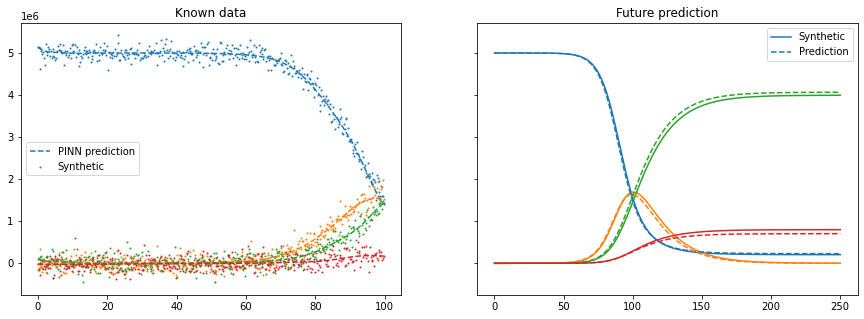

In [28]:
plot_noise.show_known_and_prediction()

Compiling model...
'compile' took 0.000120 s

Training model...

Step      Train loss                                                                                                                                                                                                  Test loss                                                                                                                                                                                                   Test metric
0         [1.42e-03, 4.34e-03, 7.18e-04, 6.44e-04, 1.02e+00, 9.48e-04, 4.40e-04, 5.77e-06, 2.37e+00, 3.95e-02, 9.70e-02, 5.93e-03, 9.43e-01, 1.36e-02, 4.71e-03, 8.40e-03, 2.14e-02, 1.22e-01, 1.87e-03, 1.27e-03]    [1.42e-03, 4.34e-03, 7.18e-04, 6.44e-04, 1.02e+00, 9.48e-04, 4.40e-04, 5.77e-06, 2.37e+00, 3.95e-02, 9.70e-02, 5.93e-03, 9.43e-01, 1.36e-02, 4.71e-03, 8.40e-03, 2.14e-02, 1.22e-01, 1.87e-03, 1.27e-03]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [2.91e-05, 4.60e-06, 9.60e-06, 6.36e-06

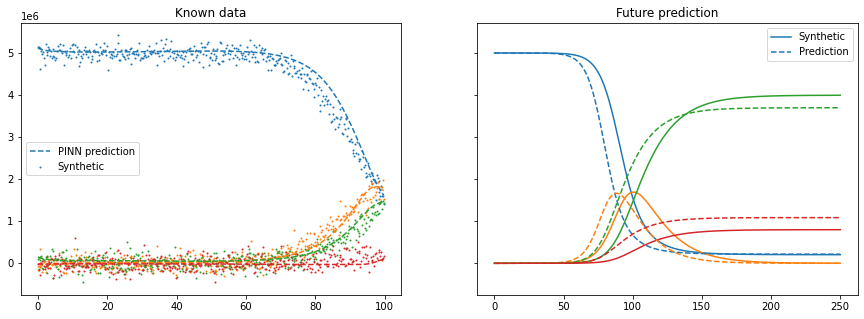

In [29]:
model_noise_neumann = SIRD_deepxde_net(t, wsol, with_neumann=True)
model_noise_neumann.init_model(print_every=1000)
model_noise_neumann.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_neumann.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_neumann.set_synthetic_data(t_synth, wsol_synth)
model_noise_neumann.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_neumann = Plot(model_noise_neumann)
plot_noise_neumann.show_known_and_prediction()

Compiling model...
'compile' took 0.000154 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.22e-04, 7.37e-02, 2.81e-02, 1.44e-02, 8.93e-01, 3.43e-04, 5.05e-04, 1.96e-04, 9.34e-01, 1.48e+00, 8.07e-01, 3.54e-01, 5.28e-01, 2.09e+00, 7.17e-01, 3.71e-01]    [1.22e-04, 7.37e-02, 2.81e-02, 1.44e-02, 8.93e-01, 3.43e-04, 5.05e-04, 1.96e-04, 9.34e-01, 1.48e+00, 8.07e-01, 3.54e-01, 5.28e-01, 2.09e+00, 7.17e-01, 3.71e-01]    []  
0 [1.00e-01, 1.00e-01, 1.00e-01]
1000      [7.34e-06, 2.50e-06, 7.47e-06, 2.35e-06, 3.03e-05, 5.20e-06, 4.29e-07, 1.56e-06, 1.54e-03, 1.02e-03, 9.39e-04, 9.97e-04, 6.39e-04, 2.29e-04, 4.61e-06, 7.92e-05]    [7.34e-06, 2.50e-06, 7.47e-06, 2.35

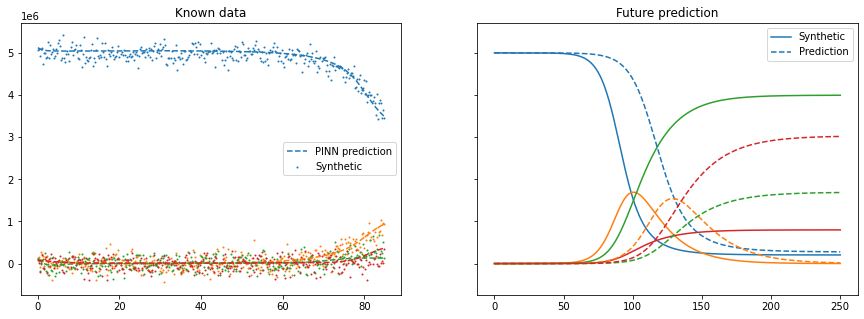

In [30]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]
wsol = solver.add_noise(wsol, scale=150000)

model_noise_less = SIRD_deepxde_net(t, wsol)
model_noise_less.init_model(print_every=1000)
model_noise_less.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_less.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_less.set_synthetic_data(t_synth, wsol_synth)
model_noise_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_less = Plot(model_noise_less)
plot_noise_less.show_known_and_prediction()

# Normal neural network

Epoch  1 : Train Loss 0.060731
Epoch 101 : Train Loss 0.001309
Epoch 201 : Train Loss 0.001313
Epoch 301 : Train Loss 0.001314
Epoch 401 : Train Loss 0.001312
Epoch 501 : Train Loss 0.001307
Epoch 601 : Train Loss 0.001286
Epoch 701 : Train Loss 0.000471
Epoch 801 : Train Loss 0.000010
Epoch 901 : Train Loss 0.000003
Epoch 1001 : Train Loss 0.000002
Epoch 1101 : Train Loss 0.000002
Epoch 1201 : Train Loss 0.000091
Epoch 1301 : Train Loss 0.000001
Epoch 1401 : Train Loss 0.000001
Epoch 1501 : Train Loss 0.000066
Epoch 1601 : Train Loss 0.000001
Epoch 1701 : Train Loss 0.000001
Epoch 1801 : Train Loss 0.000001
Epoch 1901 : Train Loss 0.000001
Epoch 2001 : Train Loss 0.000002
Epoch 2101 : Train Loss 0.000003
Epoch 2201 : Train Loss 0.000001
Epoch 2301 : Train Loss 0.000001
Epoch 2401 : Train Loss 0.000023
Epoch  1 : Train Loss 0.001176
Epoch 101 : Train Loss 0.000429
Epoch 201 : Train Loss 0.000425
Epoch 301 : Train Loss 0.000387
Epoch 401 : Train Loss 0.000085
Epoch 501 : Train Loss 0.00

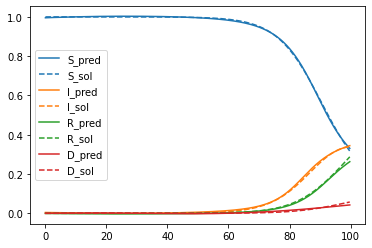

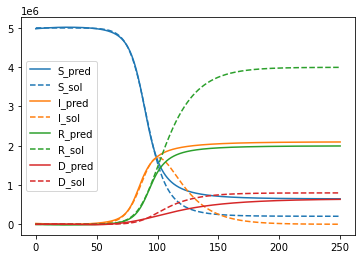

In [31]:
from SIRD_normal_nn import SIRD_net
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

net = SIRD_net(t, wsol)
net.train()
net.plot(t_synth, wsol_synth)